# Libraries

In [1]:
import cooler
import bbi
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
import cooltools
import bioframe

import tqdm

import pandas as pd
import numpy as np
import multiprocess as mp

import seaborn as sns
import matplotlib.pyplot as plt

/home/carlos/micromamba/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:651: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)
/home/carlos/micromamba/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:726: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)


In [2]:
# clr = cooler.Cooler(f"/home/carlos/oldies/manuscripts/notebooks/matrices/t0_q30.mcool::/resolutions/1000")
# bins = clr.bins()[:].iloc[:, :3]
# import bbi
# data = bbi.stackup(
#     "/home/carlos/oldies/manuscripts/notebooks/bws/XR_CPD_real_over_sim_res1000.bw",
#     bins.chrom,
#     bins.start,
#     bins.end,
#     1
# )

In [3]:
# from cooltools.api.saddle import _make_binedges

# def digitize(track_values, n_bins, vrange=None, qrange=None):
#     binedges, lo, hi = _make_binedges(
#         track_values, n_bins, vrange=vrange, qrange=qrange
#     )
#     digits = np.digitize(track_values, binedges, right=False).astype(float)
#     d_range = range(1, n_bins + 1)
#     digits = pd.Series(digits)
#     digits.loc[~digits.isin(d_range)] = pd.NA
#     return digits

# bins_d = bins.copy()
# bins_d['scaled_signal'] = digitize(data.flatten(), 1000, qrange=(0, 1))

# scaler = MinMaxScaler(feature_range=(0, 1))
# bins_d['scaled_signal'] = scaler.fit_transform(bins_d[['scaled_signal']]).flatten()
# chromsizes = bioframe.fetch_chromsizes('hg38')
# bins_d = bins_d.loc[bins_d.scaled_signal != 0]

# bioframe.to_bigwig(
#     bins_d,
#     chromsizes=chromsizes,
#     outpath="/home/carlos/oldies/manuscripts/notebooks/bws/XR_CPD_real_over_sim_res1000.scaled.bw",
#     value_field='scaled_signal',
# )

In [4]:
# bed = pd.read_csv("/home/carlos/Downloads/ENCFF950NDW.bed", sep='\t', header=None)
# def rpkm(counts):
#     return counts * 1_000_000 / counts.sum()

# bed_out = bed.copy().iloc[:, :3]
# bed_out.columns = ['chrom', 'start', 'end']
# bed_out['rpkm'] = rpkm(bed[6])
# chromsizes = bioframe.fetch_chromsizes('hg38')
# bioframe.to_bigwig(
#     bins_d,
#     chromsizes=chromsizes,
#     outpath="/home/carlos/oldies/manuscripts/notebooks/bws/dnase.rpkm.bw",
#     value_field='scaled_signal',
# )

# Prepare Data

### Eigen

In [19]:
RESOLUTION = 25_000
NPROC = 4
SAMPLES = [0, 12, 30, 60]
res_readeble = RESOLUTION // 1_000

phasing_option = "gc"
q_range = (0.05, 0.975)

rna_s1 = "0"
rna_s2 = "12"
ev_s1 = "0"
ev_s2 = "12"

ev_mapping = {
    "gc": "",
    "pol": "_pol",
}
phasing_name = ev_mapping[phasing_option]
ev_bins_df = pd.read_csv(f"e1_{res_readeble}kb{phasing_name}.tsv", sep="\t")

In [20]:
# clr = cooler.Cooler(
#     f"/home/carlos/oldies/manuscripts/notebooks/matrices/t0_q30.mcool::/resolutions/{RESOLUTION}"
# )

# view_df = pd.DataFrame(
#     {
#         "chrom": clr.chromnames,
#         "start": 0,
#         "end": clr.chromsizes.values,
#         "name": clr.chromnames,
#     }
# )
# bins = clr.bins()[:]

In [21]:
from cooltools.api.saddle import _make_binedges

def digitize(track_values, n_bins, vrange=None, qrange=None):
    binedges, lo, hi = _make_binedges(
        track_values, n_bins, vrange=vrange, qrange=qrange
    )
    digits = np.digitize(track_values, binedges, right=False).astype(float)
    d_range = range(1, n_bins + 1)
    digits = pd.Series(digits)
    digits.loc[~digits.isin(d_range)] = pd.NA
    return digits

In [22]:
# # write bigwigs
# n_bins = 1000
# chromsizes = bioframe.fetch_chromsizes('hg38')
# for i, sample in enumerate(SAMPLES):
#     bins_now = bins.iloc[:, :3].copy()
    
#     vec = eigen_data[i][1]['E1'].to_numpy()
    
#     vec = vec - np.nanmean(vec)

#     # digits = digitize(vec, n_bins, qrange=(0,1))
#     # bins_now[f"E1_{sample}"] = digits
    
#     # scaler = MinMaxScaler(feature_range=(-1, 1))
#     # bins_now[f"E1_{sample}"] = scaler.fit_transform(bins_now[f"E1_{sample}"].values.reshape(-1, 1))
#     bins_now[f"E1_{sample}"] = vec
#     #bins_now.dropna(inplace=True)
#     RESOLUTION_READABLE = f"{RESOLUTION // 1_000}kb"
#     bioframe.to_bigwig(
#         bins_now,
#         chromsizes=chromsizes,
#         outpath=f"/home/carlos/oldies/manuscripts/review/compartments/ev_bigwigs/E1_{sample}.res.{RESOLUTION_READABLE}.bw",
#         value_field=f"E1_{sample}",
#     )
#     break

In [23]:
# bins = clr.bins()[:]
# hg38_genome = bioframe.load_fasta('./hg38.fa');
# gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], hg38_genome)
# gc_cov.to_csv('hg38_gc_cov_25kb.tsv',index=False,sep='\t')
# gc_cov.to_csv('hg38_gc_cov_50kb.tsv',index=False,sep='\t')
# gc_cov.to_csv('hg38_gc_cov_100kb.tsv',index=False,sep='\t')

In [24]:
# gc_cov = pd.read_csv(f"hg38_gc_cov_{res_readeble}kb.tsv", sep="\t")

# eigen_data = []
# n_eig = 3

# for sample_idx, sample in enumerate(SAMPLES):
#     clr = cooler.Cooler(
#         f"/home/carlos/oldies/manuscripts/notebooks/matrices/t{sample}_q30.mcool::/resolutions/{RESOLUTION}"
#     )
#     map_ = mp.Pool(NPROC).map

#     cis_eigs = cooltools.eigs_cis(
#         clr, gc_cov, view_df=view_df, n_eigs=n_eig, map=map_
#     )
#     eigen_data.append(cis_eigs)

# ev_bins_df = bins.iloc[:, :3].copy()
# ev_bins_df['bin_idx'] = ev_bins_df.index
# for i, sample in enumerate(SAMPLES):
#     ev_bins_df[f"E1_{sample}"] = eigen_data[i][1]['E1'].copy().to_numpy()

# ev_bins_df.to_csv(f"e1_{res_readeble}kb_pol.tsv", sep="\t", index=False)

In [25]:
n_bins = 1000
for i, sample in enumerate(SAMPLES):
    vec = ev_bins_df[f'E1_{sample}'].copy().to_numpy()
    
    vec = vec - np.nanmean(vec)

    digits = digitize(vec, n_bins, qrange=q_range)
    ev_bins_df[f"E1_{sample}"] = digits
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    ev_bins_df[f"E1_{sample}"] = scaler.fit_transform(ev_bins_df[f"E1_{sample}"].values.reshape(-1, 1))
    

In [26]:
ev_bins_df.dropna(subset=[f"E1_{sample}" for sample in SAMPLES], inplace=True, how="all")
ev_bins_df.dropna(subset=[f"E1_{sample}" for sample in [ev_s1, ev_s2]], inplace=True, how="any")

In [27]:
# degs_df = pd.read_csv(f"/home/carlos/oldies/projects/rna-seq/t{rna_s1}-t{rna_s2}.degs.tsv", sep='\t')
# degs_df_non_sig = pd.read_csv(f"/home/carlos/oldies/projects/rna-seq/t{rna_s1}-t{rna_s2}.degs_nonSig.tsv", sep='\t')

degs_df = pd.read_csv(f"/home/carlos/oldies/projects/rna-seq/t{rna_s1}-t{rna_s2}.greaterAbs.tsv", sep='\t')
degs_df = degs_df[degs_df['log2FoldChange'].abs() >= .5]
degs_df_non_sig = pd.read_csv(f"/home/carlos/oldies/projects/rna-seq/t{rna_s1}-t{rna_s2}.lessAbs.tsv", sep='\t')
degs_df_non_sig = degs_df_non_sig[degs_df_non_sig['log2FoldChange'].abs() < .5]

In [28]:
degs_df.log2FoldChange.abs().describe()

count    2068.000000
mean        1.025024
std         0.732868
min         0.500073
25%         0.597293
50%         0.762865
75%         1.146396
max         9.316111
Name: log2FoldChange, dtype: float64

In [29]:
def parse_df(df):
    df['chrom'] =[f"chr{c}" for c in df['chrom']]
    df['start'] = df['start'].astype(int)
    df['end'] = df['end'].astype(int)
    df = df[['chrom','start','end', 'log2FoldChange', 'ensembl_gene_id', 'padj', 'strand']]
    df['gene_size'] = df['end'] - df['start']
    df['direction'] = np.sign(df['log2FoldChange'])
    map_dict = {
        1: 'Up-regulated',
        -1: 'Down-regulated',
    }
    df['direction'] = df['direction'].map(map_dict)
    return df

In [30]:
degs_df = parse_df(degs_df.copy())
degs_df_non_sig = parse_df(degs_df_non_sig.copy())
degs_df['althypo'] = 'sig_DEGs'
degs_df_non_sig['althypo'] = 'non_sig_DEGs'
merged_degs_df = pd.concat([degs_df, degs_df_non_sig])

overlap = bioframe.overlap(merged_degs_df, ev_bins_df, how='left', return_overlap=True)
overlap['overlap_size'] = overlap.overlap_end - overlap.overlap_start
overlap['sf'] = overlap['overlap_size'] / overlap['gene_size']

e1_cols = [ f"E1_{ev_s1}_", f"E1_{ev_s2}_"]

raw_df = {
    'lfc': [],
    f'ev_{ev_s1}': [],
    f'ev_{ev_s2}': [],
    'significance': [],
    'dir': [],
    'gene_id': [],
    'althypo': [],
}

for i, subset_df in overlap.groupby('ensembl_gene_id').__iter__():
    w_avg_cols = subset_df[e1_cols].apply(lambda x: np.ma.average(np.ma.MaskedArray(x, mask=np.isnan(x)), weights=subset_df['sf']), axis=0)

    raw_df['lfc'].append(subset_df['log2FoldChange'].iloc[0])
    raw_df[f'ev_{ev_s1}'].append(w_avg_cols[0])
    raw_df[f'ev_{ev_s2}'].append(w_avg_cols[1])
    raw_df['significance'].append(subset_df['padj'].iloc[0])
    raw_df['dir'].append(subset_df['direction'].iloc[0])
    raw_df['gene_id'].append(subset_df['ensembl_gene_id'].iloc[0])
    raw_df['althypo'].append(subset_df['althypo'].iloc[0])

/home/carlos/micromamba/envs/gnn/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_23827/240117085.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""])


Pair: ('Down-regulated', 'Up-regulated'), p-value: 0.0008903287035517259, n_x1 = 1518, n_x2 = 317
Pair: ('Down-regulated', 'Non-significant'), p-value: 0.021930927890674787, n_x1 = 1518, n_x2 = 4920
Pair: ('Up-regulated', 'Non-significant'), p-value: 0.012550992860160846, n_x1 = 317, n_x2 = 4920


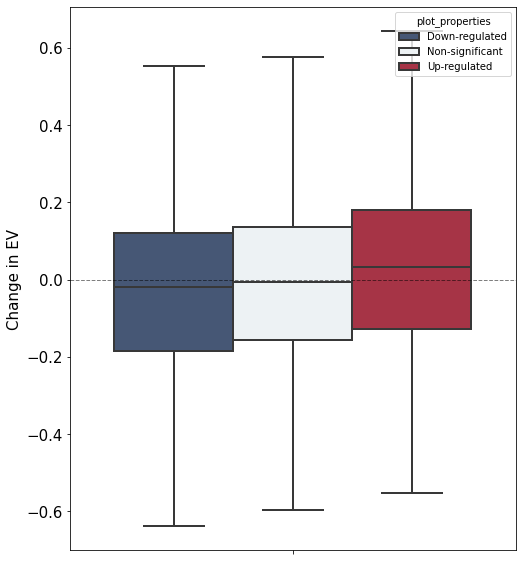

In [31]:
avg_e1_df = pd.DataFrame(raw_df)

n_random = 2000

avg_e1_df.dropna(subset=[f'ev_{ev_s1}', f'ev_{ev_s2}'], inplace=True, how='any')
avg_e1_df['ev_change'] = avg_e1_df[f'ev_{ev_s2}'].astype(float) - avg_e1_df[f'ev_{ev_s1}'].astype(float)
avg_e1_df['window'] = 0

avg_e1_df['plot_properties'] = avg_e1_df.dir.copy()
avg_e1_df.loc[avg_e1_df.althypo == 'non_sig_DEGs', 'plot_properties'] = 'Non-significant'

from statannotations.Annotator import Annotator

order = [0]
hue_order = ["Down-regulated", 'Non-significant' ,"Up-regulated"]
x = "window"

y = "ev_change"
hue = "plot_properties"

fig, ax = plt.subplots(figsize=(8, 10))

avg_e1_df.plot_properties = pd.Categorical(avg_e1_df.plot_properties, categories=hue_order, ordered=True)

# sns.swarmplot(data=avg_e1_df, x=x, y=y, order=order, hue=hue, hue_order=hue_order, 
#               palette=['#465775', '#A63446', '#edf2f4'], ax=ax, dodge=True, alpha=1)
# ax = sns.boxplot(data=avg_e1_df, x=x, y=y, order=order, hue=hue, hue_order=hue_order, 
#                  showfliers=False, linewidth=2, palette=['black'], ax=ax, boxprops={'alpha': 0.7})

# ax = sns.violinplot(data=avg_e1_df, x=x, y=y, order=order, hue=hue, hue_order=hue_order, 
#                  showfliers=False, linewidth=2, palette=['#465775', '#A63446', '#edf2f4'], ax=ax, )

avg_e1_df.to_csv(f"ev_change_{ev_s1}_{ev_s2}.tsv", sep="\t", index=False)
ax = sns.boxplot(data=avg_e1_df, x=x, y=y, order=order, hue=hue, hue_order=hue_order, showfliers=False, linewidth=2, palette=['#465775', '#edf2f4', '#A63446',], ax=ax, saturation=1)
ax.axhline(0, ls='--', color='black', lw=1, alpha=0.5)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

ax.set_ylabel("Change in EV", fontsize=15)
ax.set_xlabel("")
ax.set_xticklabels([""])


# add horizontal line

# pairs = [
#     ((0,"Down-regulated") , (0,"Up-regulated")),
#     ((1,"Down-regulated") , (1,"Up-regulated")),
#     ((2,"Down-regulated") , (2,"Up-regulated")),
#     ((3,"Down-regulated") , (3,"Up-regulated"))
#     ]

pairs = [
    ("Down-regulated" , "Up-regulated"),
    ("Down-regulated" , "Non-significant"),
    ("Up-regulated" , "Non-significant"),
    ]

from scipy.stats import mannwhitneyu

for pair in pairs:
    x1 = avg_e1_df.loc[avg_e1_df.plot_properties == pair[0], 'ev_change'].dropna()
    x2 = avg_e1_df.loc[avg_e1_df.plot_properties == pair[1], 'ev_change'].dropna()
    stat, p = mannwhitneyu(x1, x2)
    print(f"Pair: {pair}, p-value: {p}, n_x1 = {len(x1)}, n_x2 = {len(x2)}")

fig.savefig(f"ev_change_{ev_s1}_{ev_s2}.svg", bbox_inches='tight')

In [32]:
avg_e1_df.plot_properties.value_counts()

Non-significant    5365
Down-regulated     1692
Up-regulated        376
Name: plot_properties, dtype: int64